# Quantum-Based Resiliency Planning

This notebook implements the quantum-based resiliency planning using QAOA.


In [35]:
import math
import random
from itertools import product
from platform import node

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm

from classiq import *
from classiq.execution import ExecutionPreferences, ExecutionSession

# Imports

### Create the graph

/var/folders/r8/5nlfyms56kj96_c21bgv36040000gn/T/ipykernel_86414/3897101284.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


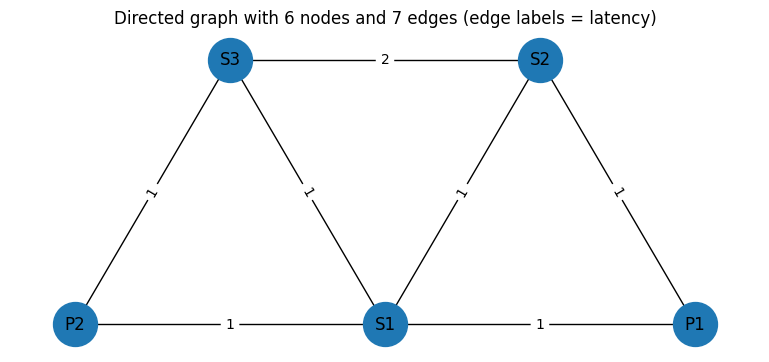


Demands (2 total):
  Demand Source Target
0     d1     S2     P1
1     d2     S2     P2

Z (D x (m+n)) binary matrix — rows=demand, cols=edge (initialized to 0):
           (P1,S1)  (P1,S2)  (S2,S1)  (P2,S1)  (S3,S1)  (P2,S3)  (S3,S2)  P1  \
d1(S2→P1)        0        1        0        0        0        0        0   1   
d2(S2→P2)        0        0        0        0        0        1        1   0   

           P2  S1  S2  S3  
d1(S2→P1)   0   0   1   0  
d2(S2→P2)   1   0   1   1  


In [36]:
# ---- Graph ----
graph = nx.Graph()
V = ["P1", "P2", "S1", "S2", "S3"]
graph.add_nodes_from(V)

E_with_weights = [
    ("P1", "S1", {"lat": 1, "perr": 0.1}),
    ("P1", "S2", {"lat": 1, "perr": 0.1}),
    ("S2", "S1", {"lat": 1, "perr": 0.1}),
    ("P2", "S1", {"lat": 1, "perr": 0.1}),
    ("S3", "S1", {"lat": 1, "perr": 0.1}),
    ("P2", "S3", {"lat": 1, "perr": 0.1}),
    ("S3", "S2", {"lat": 2, "perr": 0.1}),
]

lat_vec = np.array([w["lat"] for (_, _, w) in E_with_weights], dtype=float)
perr_vec = np.array([w["perr"] for (_, _, w) in E_with_weights], dtype=float)
graph.add_edges_from(E_with_weights)

E = graph.edges()
lat = {(u, v): w["lat"] for (u, v, w) in E_with_weights}
perr = {(u, v): w["perr"] for (u, v, w) in E_with_weights}
ordered_edges = [(u, v) for (u, v, _) in E_with_weights]
edge_ids = [f"({u},{v})" for (u, v) in ordered_edges]
ids = edge_ids + V


def weight_of_e(u, v, weights):
    if (u, v) in lat.keys():
        return weights[(u, v)]
    return weights[(v, u)]


def lat_of_e(u, v):
    return weight_of_e(u, v, lat)


def perr_of_e(u, v):
    return weight_of_e(u, v, perr)


# ---- Demands ----
# From S2
source_node = "S2"
demands = [
    {"name": "d1", "s": source_node, "t": "P1"},
    {"name": "d2", "s": source_node, "t": "P2"},
]

D = len(demands)
m = len(E)
n = len(V)

# ---- Z 2D matrix ----
row_len = m + n
Z = np.zeros((D, (m + n)), dtype=int)

# Creating the solution we aim to get
Z[0, 1] = Z[0, 7] = Z[0, 10] = 1
Z[1, 5] = Z[1, 6] = Z[1, 11] = Z[1, 10] = Z[1, 8] = 1


Z_df = pd.DataFrame(
    Z, index=[f"{d['name']}({d['s']}→{d['t']})" for d in demands], columns=ids
)

# ---- Plot ----
pos = {
    "P1": (2.0, 1.0),
    "P2": (1.0, 1.0),
    "S1": (1.5, 1.0),
    "S2": (1.75, 2.0),
    "S3": (1.25, 2.0),
}
plt.figure(figsize=(7.5, 3.2))
nx.draw(graph, pos, with_labels=True, node_size=1000)
nx.draw_networkx_edge_labels(
    graph, pos, edge_labels={(u, v): f"{lat_of_e(u,v)}" for (u, v) in E}
)
plt.title("Directed graph with 6 nodes and 7 edges (edge labels = latency)")
plt.tight_layout()
plt.show()


print("\nDemands (2 total):")
print(
    pd.DataFrame(
        [{"Demand": d["name"], "Source": d["s"], "Target": d["t"]} for d in demands]
    )
)

print("\nZ (D x (m+n)) binary matrix — rows=demand, cols=edge (initialized to 0):")
print(Z_df)

In [37]:
num_edges = len(ordered_edges)
err_correlation = np.full((num_edges, num_edges), 0)
correlated = True
i = j = 0
for index, (u1, v1) in enumerate(ordered_edges):
    if (u1, v1) in [("P1", "S2"), ("S2", "P1")]:
        i = index
    if (u1, v1) in [("S1", "S2"), ("S2", "S1")]:
        j = index
assert i != j != 0
if correlated:
    err_correlation[i, j] = err_correlation[j, i] = 1
err_correlation

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

For convience and easy visualization, let's add a helper function that prints the solution into the graph.

This function gets our assigned solution (the 2D array of binary variables).

           (P1,S1)  (P1,S2)  (S2,S1)  (P2,S1)  (S3,S1)  (P2,S3)  (S3,S2)  P1  \
d1(S2→P1)        0        1        0        0        0        0        0   1   
d2(S2→P2)        0        0        0        0        0        1        1   0   

           P2  S1  S2  S3  
d1(S2→P1)   0   0   1   0  
d2(S2→P2)   1   0   1   1  


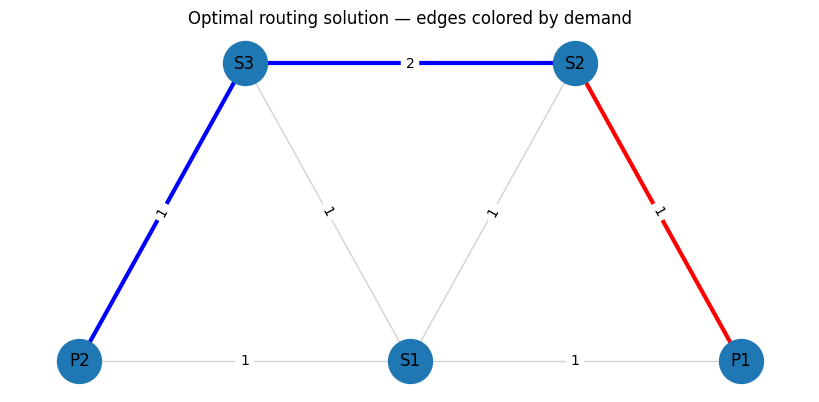

In [38]:
import matplotlib.pyplot as plt


def get_edge(u, v, arr):
    if (u, v) in arr:
        return (u, v)
    return (v, u)


def print_solution_graph(assigned_z, index=None):
    # Assign a distinct color per demand
    colors_for_demands = ["red", "blue", "green", "yellow"]
    edge_colors = []
    edge_widths = []
    node_colors = []

    # Build a mapping from edge -> demand index (if chosen)
    edge_to_demand = {}
    for d_idx, d in enumerate(demands):
        for e_idx, (u, v) in enumerate(ordered_edges):
            if assigned_z[d_idx, e_idx] == 1:
                edge_to_demand[(u, v)] = d_idx

    # Create color list for all edges in E
    for u, v in E:
        if (u, v) in edge_to_demand or (v, u) in edge_to_demand:
            demand_idx = edge_to_demand[get_edge(u, v, edge_to_demand)]
            edge_colors.append(colors_for_demands[demand_idx])
            edge_widths.append(3.0)
        else:
            edge_colors.append("lightgray")
            edge_widths.append(1.0)

    # Plot the graph
    plt.figure(figsize=(8, 3.6))
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=1000,
        edge_color=edge_colors,
        width=edge_widths,
    )
    nx.draw_networkx_edge_labels(
        graph, pos, edge_labels={(u, v): f"{lat_of_e(u,v)}" for (u, v) in ordered_edges}
    )
    if index is not None:
        plt.title(
            f"Routing solution for sample index {index} — edges colored by demand"
        )
    else:
        plt.title("Optimal routing solution — edges colored by demand")
    plt.show()


print(Z_df)
print_solution_graph(Z)

In [39]:
# The mixer Hamiltonian is effectively X/2 and has eigenvalues -0.5 and +0.5. So the difference between minimum and maximum eigenvalues is exactly 1.
# This can be rescaled by a global scaling parameter.
GlobalScalingParameter = 1

# The constraint Hamiltonian has the property that a minimal constraint violation is 1 and no constraint violation is 0.
# We wish to normalise the constraint Hamiltonian relative to the total cost Hamiltonian such that the constraint violation will be 1~2 x larger than the maximal difference between total cost values.
RelativeConstraintNormalisation = 5

# The cost Hamiltonian should be similar in eigenvalue difference to the mixer Hamiltonian and should be normalised to about 1.
# To find the exact normalisation requires solving this NP hard problem so we always use approximation.
# Since this is approximate, there is a relative scaling parameter we can twitch
RelativeCostNormalisation = 1 / 40

TotalCostNormalisation = GlobalScalingParameter * RelativeCostNormalisation
TotalConstraintNormalisation = RelativeConstraintNormalisation * TotalCostNormalisation

# B stands for the relationship between error correlation and latency
B = 10

# Normalize latencies
min_lat_guess = (
    3  # can be calculated with Dijkstra when removing the single assignment constraint
)
max_lat_guess = 4  # any guess that fits the constraints will work

lat_normalized = {}
for e, w in lat.items():
    lat_normalized[e] = w * TotalCostNormalisation / (max_lat_guess - min_lat_guess)

min_prob_guess = 0.03
max_prob_guess = 1.0

print(lat_normalized)

{('P1', 'S1'): 0.025, ('P1', 'S2'): 0.025, ('S2', 'S1'): 0.025, ('P2', 'S1'): 0.025, ('S3', 'S1'): 0.025, ('P2', 'S3'): 0.025, ('S3', 'S2'): 0.05}


### Helper Functions

In [40]:
def edge_fidx(d_idx, e_idx):
    return d_idx * row_len + e_idx


def node_fidx(d_idx, n_idx):
    return d_idx * row_len + n_idx + m

### Define Objective Function

In [41]:
def sum_per_array(assigned_z, array):
    return sum(
        (array[e] * assigned_z[edge_fidx(d_idx, e_idx)])
        for d_idx, d in enumerate(demands)
        for e_idx, e in enumerate(ordered_edges)
    )


# Objective: sum_d sum_e lat_e * Z[d,e]
def objective_func(assigned_z):
    lat_sum = sum_per_array(assigned_z, lat_normalized)
    return lat_sum

### Define Single Assignment Cosntraint

In [42]:
def edges_per_node(node):
    for edge_idx, edge in enumerate(ordered_edges):
        if node in edge:
            yield edge_idx


def flow_conservation_per_node_per_demand(
    node, node_idx, demand_idx, demand, assigned_z
):
    node_flow = 0

    # If node is the start/end of this demand, add 1 imaginary edge
    if node in demand.values():
        node_flow += 1

    # If the node is in the path, subtract 2 required edges
    node_flow -= 2 * assigned_z[node_fidx(d_idx=demand_idx, n_idx=node_idx)]

    # Add 1 edge for each used edge for this node
    for edge_idx in edges_per_node(node):
        node_flow += assigned_z[edge_fidx(d_idx=demand_idx, e_idx=edge_idx)]

    # Valid solution should have node_flow == 0 since:
    # * For nodes not in the path - no edges should be chosen
    # * For nodes in the path, there should be exactly 2 edges, or 1 edge for start/end ( + imaginary edge)
    return node_flow**2


def my_not(value):
    # Assumes value is 0 or 1
    return 1 - value


def constraint_starting_nodes(assigned_z):
    return sum(
        my_not(assigned_z[node_fidx(d_idx=demand_idx, n_idx=V.index(v_of_demand))])
        for demand_idx, demand in enumerate(demands)
        for v_of_demand in list(demand.values())[1:]
    )


def constraint_flow_conservation(assigned_z):
    total_flow = sum(
        flow_conservation_per_node_per_demand(
            node=node,
            node_idx=node_idx,
            demand=demand,
            demand_idx=demand_idx,
            assigned_z=assigned_z,
        )
        for node_idx, node in enumerate(V)
        for demand_idx, demand in enumerate(demands)
    )
    return total_flow + constraint_starting_nodes(assigned_z)

In [43]:
def sum_correlation(assigned_z):
    return sum(
        err_correlation[e1_idx, e2_idx]
        * assigned_z[edge_fidx(0, e1_idx)]
        * assigned_z[edge_fidx(1, e2_idx)]
        for e1_idx in range(len(ordered_edges))
        for e2_idx in range(len(ordered_edges))
        if err_correlation[e1_idx, e2_idx] > 0
    )


def node_resiliency(assigned_z):
    return sum(
        B
        * TotalCostNormalisation
        * assigned_z[node_fidx(d_idx=0, n_idx=node_idx)]
        * assigned_z[node_fidx(d_idx=1, n_idx=node_idx)]
        for node_idx in range(len(V))
        if V[node_idx] is not source_node
    )


def objective_minimal_resiliency(assigned_z):
    return sum_correlation(assigned_z)

In [44]:
def cost_hamiltonian(assigned_Z):
    return (
        objective_func(assigned_Z)
        + node_resiliency(assigned_Z)
        + objective_minimal_resiliency(assigned_Z)
        + TotalConstraintNormalisation * (constraint_flow_conservation(assigned_Z))
    )

## Create QAOA Code

In [45]:
NUM_LAYERS = 20


@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(GlobalScalingParameter * beta, q), qba)


@qfunc
def cost_layer(gamma: CReal, qba: QArray[QBit]):
    phase(phase_expr=cost_hamiltonian(qba), theta=gamma)


@qfunc
def main(
    params: CArray[CReal, 2 * NUM_LAYERS],
    z: Output[QArray[QBit, D * row_len]],
) -> None:
    allocate(z)
    hadamard_transform(z)

    repeat(
        count=NUM_LAYERS,
        iteration=lambda i: (
            cost_layer(params[2 * i], z),
            mixer_layer(params[2 * i + 1], z),
        ),
    )


write_qmod(main, "resiliency_planning")

In [46]:
qprog = synthesize(main)

In [47]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36se9nqbGvihLDB2r99kNvBvajj


In [48]:
print(f"Width is {qprog.data.width}")
print(f"Depth is {qprog.transpiled_circuit.depth}")
print(f"Number of gates is {qprog.transpiled_circuit.count_ops}")

Width is 24
Depth is 586
Number of gates is {'cx': 2480, 'rz': 1720, 'rx': 480, 'h': 24}


## Execute QAOA

In [49]:
NUM_SHOTS = 20000
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR
)

es = ExecutionSession(
    qprog,
    execution_preferences=ExecutionPreferences(
        num_shots=NUM_SHOTS,
    ),
)


def initial_qaoa_params(NUM_LAYERS) -> np.ndarray:
    initial_gammas = math.pi * np.linspace(
        1 / (2 * NUM_LAYERS), 1 - 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )
    initial_betas = math.pi * np.linspace(
        1 - 1 / (2 * NUM_LAYERS), 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )

    initial_params = []

    for i in range(NUM_LAYERS):
        initial_params.append(initial_gammas[i])
        initial_params.append(initial_betas[i])

    return np.array(initial_params)


initial_params = initial_qaoa_params(NUM_LAYERS)

In [50]:
cost_func = lambda state: cost_hamiltonian(state["z"])


def estimate_cost_func(params):
    objective_val = es.estimate_cost(cost_func, {"params": params.tolist()})
    print(f"Cost Hamiltonian = {np.round(objective_val, decimals=3)}")
    return objective_val

In [57]:
MAX_ITERATIONS = 1  # Increase to improve the results
optimization_res = minimize(
    estimate_cost_func,
    x0=initial_params,
    method="COBYLA",
    options={"maxiter": MAX_ITERATIONS},
)

Cost Hamiltonian = 1.387


In [58]:
res = es.sample({"params": optimization_res.x.tolist()})

In [59]:
def check_validity(assigned_z: list[int]) -> bool:
    if constraint_flow_conservation(assigned_z) != 0:
        return False
    if node_resiliency(assigned_z) != 0:
        return False
    return True

In [60]:
sorted_counts = sorted(res.parsed_counts, key=lambda pc: pc.shots, reverse=True)


def print_res(sampled, idx):
    assigned_z = sampled.state["z"]
    if not check_validity(assigned_z):
        return
    valid_solutions_indices.append(idx)
    print(
        f"Valid solution found at index {idx}, probability={sampled.shots/NUM_SHOTS*100}%, cost={cost_hamiltonian(assigned_z)}, latency={round(objective_func(assigned_z) / TotalCostNormalisation * (max_lat_guess - min_lat_guess))}"
    )


valid_solutions_indices = []
for idx, sampled in enumerate(sorted_counts[:100]):
    print_res(sampled, idx)

print(
    f"Accumulated valid probability is {sum(sampled.shots for sampled in sorted_counts if check_validity(sampled.state['z']))/NUM_SHOTS*100}%"
)

Valid solution found at index 0, probability=0.64%, cost=0.1, latency=4
Valid solution found at index 5, probability=0.375%, cost=0.125, latency=5
Valid solution found at index 9, probability=0.265%, cost=0.125, latency=5
Valid solution found at index 78, probability=0.075%, cost=1.075, latency=3
Accumulated valid probability is 1.3599999999999999%


In [61]:
def convert_1d_to_2d(array_1d):
    array_2d = np.zeros((D, row_len))
    for d_idx in range(D):
        for e_idx in range(m):
            array_2d[d_idx][e_idx] = array_1d[edge_fidx(d_idx, e_idx)]
        for n_idx in range(n):
            array_2d[d_idx][m + n_idx] = array_1d[node_fidx(d_idx, n_idx)]
    return array_2d

0


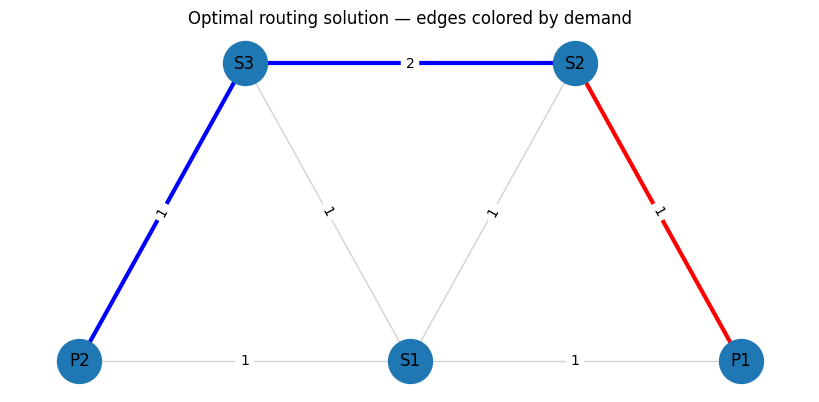

           (P1,S1)  (P1,S2)  (S2,S1)  (P2,S1)  (S3,S1)  (P2,S3)  (S3,S2)   P1  \
d1(S2→P1)      0.0      1.0      0.0      0.0      0.0      0.0      0.0  1.0   
d2(S2→P2)      0.0      0.0      0.0      0.0      0.0      1.0      1.0  0.0   

            P2   S1   S2   S3  
d1(S2→P1)  0.0  0.0  1.0  0.0  
d2(S2→P2)  1.0  0.0  1.0  1.0  
objective_func(solution)/TotalCostNormalisation * (max_lat_guess-min_lat_guess)=4.0
cost=0.1
Flow Conservation: 0
Resiliency: 0.0
5


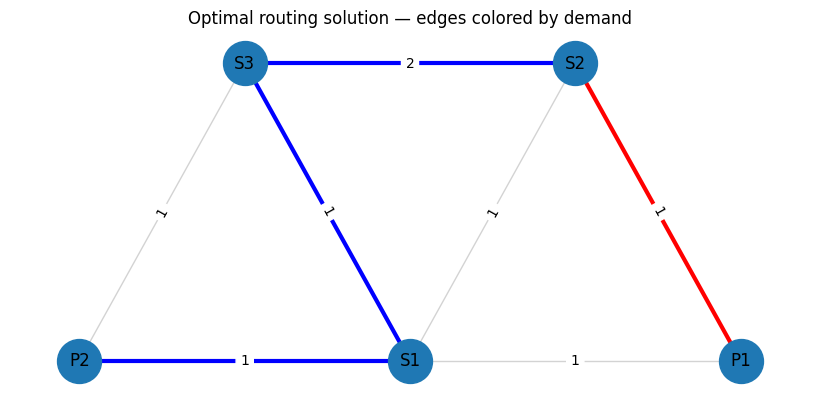

           (P1,S1)  (P1,S2)  (S2,S1)  (P2,S1)  (S3,S1)  (P2,S3)  (S3,S2)   P1  \
d1(S2→P1)      0.0      1.0      0.0      0.0      0.0      0.0      0.0  1.0   
d2(S2→P2)      0.0      0.0      0.0      1.0      1.0      0.0      1.0  0.0   

            P2   S1   S2   S3  
d1(S2→P1)  0.0  0.0  1.0  0.0  
d2(S2→P2)  1.0  1.0  1.0  1.0  
objective_func(solution)/TotalCostNormalisation * (max_lat_guess-min_lat_guess)=5.0
cost=0.125
Flow Conservation: 0
Resiliency: 0.0
9


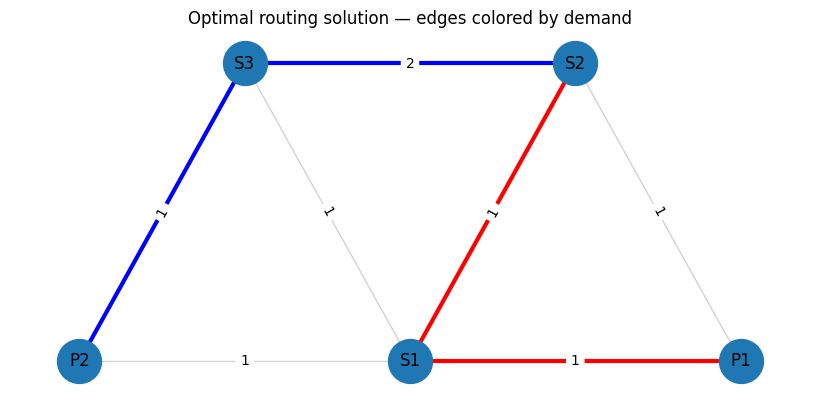

           (P1,S1)  (P1,S2)  (S2,S1)  (P2,S1)  (S3,S1)  (P2,S3)  (S3,S2)   P1  \
d1(S2→P1)      1.0      0.0      1.0      0.0      0.0      0.0      0.0  1.0   
d2(S2→P2)      0.0      0.0      0.0      0.0      0.0      1.0      1.0  0.0   

            P2   S1   S2   S3  
d1(S2→P1)  0.0  1.0  1.0  0.0  
d2(S2→P2)  1.0  0.0  1.0  1.0  
objective_func(solution)/TotalCostNormalisation * (max_lat_guess-min_lat_guess)=5.0
cost=0.125
Flow Conservation: 0
Resiliency: 0.0
78


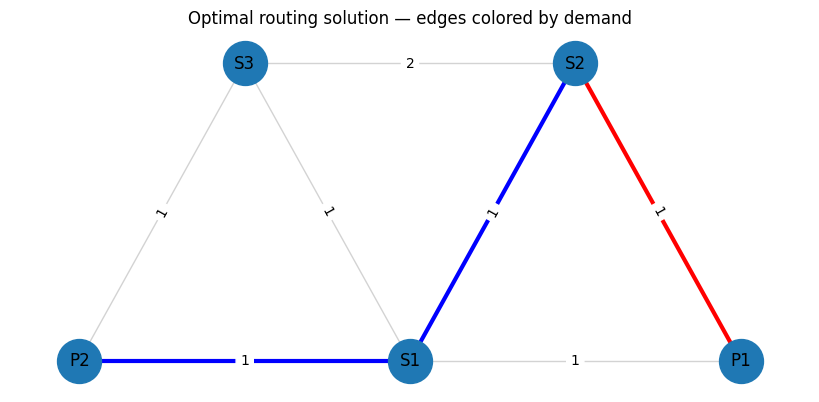

           (P1,S1)  (P1,S2)  (S2,S1)  (P2,S1)  (S3,S1)  (P2,S3)  (S3,S2)   P1  \
d1(S2→P1)      0.0      1.0      0.0      0.0      0.0      0.0      0.0  1.0   
d2(S2→P2)      0.0      0.0      1.0      1.0      0.0      0.0      0.0  0.0   

            P2   S1   S2   S3  
d1(S2→P1)  0.0  0.0  1.0  0.0  
d2(S2→P2)  1.0  1.0  1.0  0.0  
objective_func(solution)/TotalCostNormalisation * (max_lat_guess-min_lat_guess)=3.0000000000000004
cost=1.075
Flow Conservation: 0
Resiliency: 0.0


In [62]:
def print_solution(index):
    print(index)
    solution = sorted_counts[index].state["z"]
    sol_2d = convert_1d_to_2d(solution)
    print_solution_graph(sol_2d)
    sol_df = pd.DataFrame(
        sol_2d, index=[f"{d['name']}({d['s']}→{d['t']})" for d in demands], columns=ids
    )
    print(sol_df)
    print(
        f"{objective_func(solution)/TotalCostNormalisation * (max_lat_guess-min_lat_guess)=}"
    )
    print(f"cost={cost_hamiltonian(solution)}")
    print(f"Flow Conservation: {constraint_flow_conservation(solution)}")
    print(f"Resiliency: {node_resiliency(solution)}")


# for index in valid_solutions_indices:
for index in valid_solutions_indices:
    print_solution(index)